# Assignment 5 BMEG 424

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
data = "/content/data/MPRA_data.txt"# path to the data file"
# read in the data
data = pd.read_csv(data, sep='\t', header=None)
# rename the columns
data.columns = ['sequence', 'expression']
# set up the label binarizer from sklearn
lb = LabelBinarizer()
lb.fit(list('ACGT'))
# function for one hot encoding the data
def one_hot_encode(sequence):
    return lb.transform(list(sequence))
# one hot encode the sequence
data['ohc_sequence'] = data['sequence'].apply(one_hot_encode) # this line is using the pandas apply function to run the one_hot_encode function on each row of the dataframe
# preview result
print("Preprocessed data preview: ")
print(data.head())

Preprocessed data preview: 
                                            sequence  expression  \
0  CTCCGGCCCTATGCAATCGAGTTATTGCGAGTGCGTTATTGGGAAC...       0.445   
1  ATTCAAATCTTACTTTTCAGTATAGGAGTTTCTTGCGTAAACTGCT...       0.440   
2  TTGGTCCGGGGCTGACACCCCACCCACCGAAAGAGGCTGCACCAAA...       0.665   
3  TGAAGTTTGCAATAGAACCAGTCAAGATGGTTTCCCTAAAGATAGC...       0.345   
4  TGGGGGGAAGGTTTGGCTTAGGGTACGGGGTTAACAGTTTACAACG...       0.515   

                                        ohc_sequence  
0  [[0, 1, 0, 0], [0, 0, 0, 1], [0, 1, 0, 0], [0,...  
1  [[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0,...  
2  [[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 1, 0], [0,...  
3  [[0, 0, 0, 1], [0, 0, 1, 0], [1, 0, 0, 0], [1,...  
4  [[0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 0], [0,...  


In [2]:
print("The original single sequency shape is: ", len(data['sequence'][0]))
print("The single one-hot encoded sequence shape is: ", data['ohc_sequence'][0].shape)

The original single sequency shape is:  200
The single one-hot encoded sequence shape is:  (200, 4)


In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

# split the data into X and y
X = np.stack(data['ohc_sequence'])
y = data['expression'].values

# split the data into training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=12)

# save the data (if you are working on google colab your variables work across cells so you don't technically need to save the data, you can just use the variables in the next cell)
# however if you run into problems it will be easier for the instructor to help you if you have saved the data
np.save('X_train.npy', X_train)
np.save('X_val.npy', X_val)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_val.npy', y_val)
np.save('y_test.npy', y_test)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("X_val: ", X_val.shape)

print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)
print("y_val: ", y_val.shape)



X_train:  (6000, 200, 4)
X_test:  (2000, 200, 4)
X_val:  (2000, 200, 4)
y_train:  (6000,)
y_test:  (2000,)
y_val:  (2000,)


# Part 1

Simple NN

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
def create_simple_nn():
  input_shape = (200, 4)

  simple_nn = Sequential([
      Flatten(input_shape=input_shape),   # Flatten the input
      Dense(512, activation='relu'),      # Fully connected layer with 512 units
      Dense(256, activation='relu'),       # Fully connected layer with 256 units
      Dense(1)                            # Output layer with 1 unit (for regression)
  ])

  return simple_nn

In [5]:
#Enable GPU (Runtime->Change runtime type -> GPU)
import tensorflow as tf
assert tf.config.list_physical_devices('GPU')

In [6]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Create the model
simple_nn = create_simple_nn()
simple_nn.summary()
simple_nn.compile(optimizer=tf.keras.optimizers.SGD(lr = 1e-1), loss='mse')

# Setup callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_simple_nn_model.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

# Train the model
history = simple_nn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=1024, callbacks=[checkpoint], verbose=1)

# Evaluate the model
# Load the best weights
simple_nn.load_weights('best_simple_nn_model.h5')
y_pred = simple_nn.predict(X_test)

# Print the R2 score
r2= r2_score(y_test, y_pred)
print("R2 score (simple Neural Network): ", r2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 512)               410112    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 541697 (2.07 MB)
Trainable params: 541697 (2.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
6/6 [==============================] - ETA: 0s - loss: 0.1164 
Epoch 1: val_loss improved from inf to 0.08159, saving model to best_simple_nn_model.h5
6/6 [==============================] - 4s 115ms/step - loss: 0.1164 - val_loss: 0.0816
Epoch 2/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0817
Epoch 2: val_loss improved from 0.08159 to 0.07415, saving model to best_simple_nn_model.h5
6/6 [==============================] - 0s 30ms/step - loss: 0.0808 - val_loss: 0.0741
Epoch 3/50
5/6 [========================>.....] - ETA: 0s - loss: 0.0741
Epoch 3: val_loss improved from 0.07415 to 0.06920, saving model to best_simple_nn_model.h5
6/6 [==============================] - 0s 29ms/step - loss: 0.0740 - val_loss: 0.0692
Epoch 4/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0718
Epoch 4: val_loss improved from 0.06920 to 0.06507, saving model to best_simple_nn_model.h5
6/6 [==============================] - 0s 29ms/step - loss: 0.0687 - val_loss: 0.065

CNN

In [7]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
from sklearn.metrics import mean_squared_error, r2_score

def create_CNN_model():
    model = Sequential([
    Conv1D(filters=32, kernel_size=17, activation='relu', input_shape=(X_train.shape[1], 4)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=17, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
  ])
    return model

# Create the model
CNN_model = create_CNN_model()
CNN_model.summary()
CNN_model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4), loss='mse')

# Set up callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_CNN_model.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

# Train the model
CNN_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=1024, callbacks=[checkpoint], verbose=1)

# Evaluate the model
# Load the best weights
CNN_model.load_weights('best_CNN_model.h5')
y_pred = CNN_model.predict(X_test)

# Print the R2 score
r2 = r2_score(y_test, y_pred)
print("R2 score (Conv Neural Network): ", r2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 184, 32)           2208      
                                                                 
 max_pooling1d (MaxPooling1  (None, 92, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 76, 64)            34880     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 38, 64)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2432)              0         
                                                                 
 dense_3 (Dense)             (None, 64)               

Epoch 1/50
6/6 [==============================] - ETA: 0s - loss: 0.2263
Epoch 1: val_loss improved from inf to 0.12021, saving model to best_CNN_model.h5
6/6 [==============================] - 5s 360ms/step - loss: 0.2263 - val_loss: 0.1202
Epoch 2/50
5/6 [========================>.....] - ETA: 0s - loss: 0.0574
Epoch 2: val_loss improved from 0.12021 to 0.04081, saving model to best_CNN_model.h5
6/6 [==============================] - 0s 29ms/step - loss: 0.0557 - val_loss: 0.0408
Epoch 3/50
5/6 [========================>.....] - ETA: 0s - loss: 0.0183
Epoch 3: val_loss improved from 0.04081 to 0.01660, saving model to best_CNN_model.h5
6/6 [==============================] - 0s 26ms/step - loss: 0.0182 - val_loss: 0.0166
Epoch 4/50
5/6 [========================>.....] - ETA: 0s - loss: 0.0084
Epoch 4: val_loss improved from 0.01660 to 0.00920, saving model to best_CNN_model.h5
6/6 [==============================] - 0s 26ms/step - loss: 0.0079 - val_loss: 0.0092
Epoch 5/50
5/6 [=======

Baseline: Linear Regression

In [8]:
# again you can copy this code into the same google colab session in a new cell and run it to get the results
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Create the model
reg = LinearRegression().fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Evaluate the model
y_pred = reg.predict(X_test.reshape(X_test.shape[0], -1))
# Save predictions to an npy file
np.save('y_pred_linearRegressor.npy', y_pred)
# Print the R2 score
r2 = r2_score(y_test, y_pred)
print("R2 score: ", r2)

R2 score:  1.0


# Part 2

PCA

In [9]:
import h5py
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# import h5 data
path = "/content/data/scRNA_counts.h5"
with h5py.File(path, 'r') as f:
    X = f['X'][:]
print(X[:5])

X = StandardScaler().fit_transform(X)
# Perform PCA
pca = PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)

[[ 5  0  8 ...  0  9 19]
 [ 1  0  2 ...  0  3 27]
 [ 4  2 19 ...  0  0 32]
 [ 5  0 19 ...  0  0 15]
 [ 0  0  7 ...  0  7 34]]


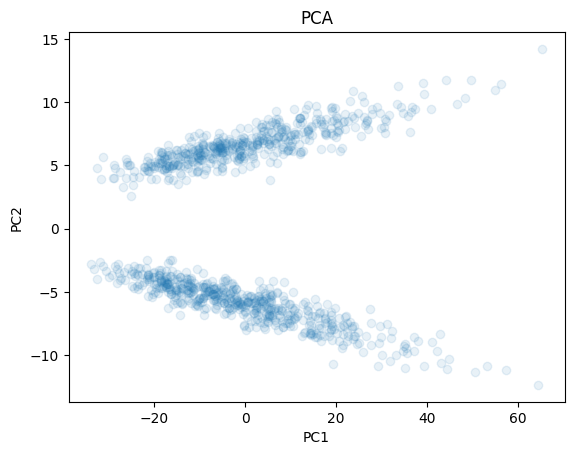

In [10]:
import matplotlib.pyplot as plt
# Plot the PCA
plt.scatter(X[:, 0], X[:, 1], alpha=0.1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA')
plt.show()

Kmeans:

In [11]:
from sklearn.cluster import KMeans

# Perform KMeans clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
labels_kmeans = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Hierarchical cluster:

In [12]:
from sklearn.cluster import AgglomerativeClustering
agglomerative = AgglomerativeClustering(n_clusters=2)
labels_agglomerative = agglomerative.fit_predict(X)

DBSCAN:

In [13]:
from sklearn.cluster import DBSCAN
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.1).fit(X)
labels_dbscan = dbscan.labels_

Visualization

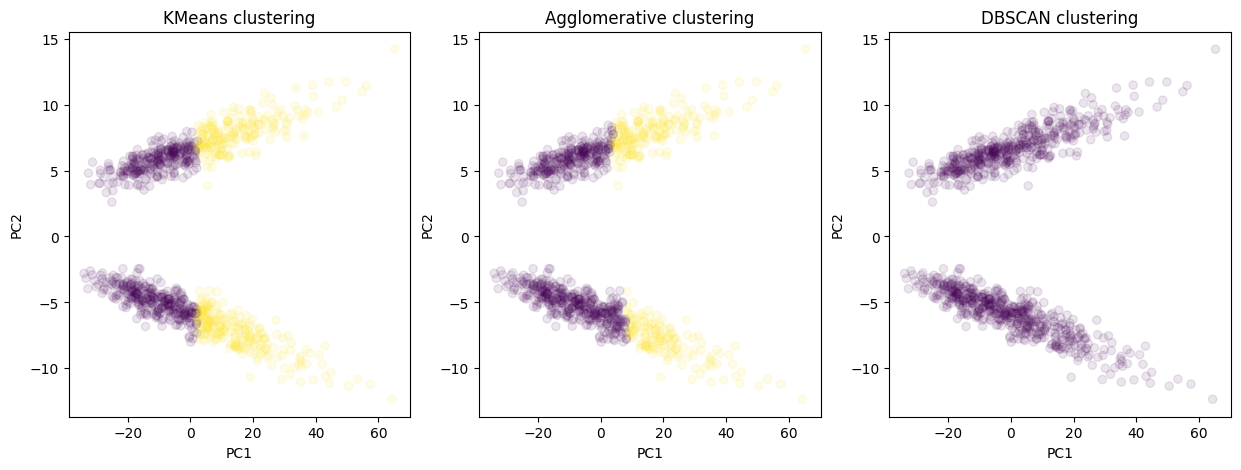

In [14]:
# Add all figures to the same plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(X[:, 0], X[:, 1], c=labels_kmeans, alpha=0.1)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[0].set_title('KMeans clustering')
ax[1].scatter(X[:, 0], X[:, 1], c=labels_agglomerative, alpha=0.1)
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC2')
ax[1].set_title('Agglomerative clustering')
ax[2].scatter(X[:, 0], X[:, 1], c=labels_dbscan, alpha=0.1)
ax[2].set_xlabel('PC1')
ax[2].set_ylabel('PC2')
ax[2].set_title('DBSCAN clustering')
plt.show()

In [15]:
print(np.unique(labels_dbscan))

[-1]


# Discussion

Question 8:

In [16]:
df = pd.DataFrame(reg.coef_.reshape((200,4)), columns=["A", "C", "G", "T"])
df.describe()

,A,C,G,T
count,200.000000,200.000000,200.000000,200.000000
mean,-0.002509,0.002491,0.002491,-0.002509
std,0.000317,0.000317,0.000317,0.000317
min,-0.003459,0.001541,0.001541,-0.003459
25%,-0.002706,0.002294,0.002294,-0.002706
50%,-0.002525,0.002475,0.002475,-0.002525
75%,-0.002297,0.002703,0.002703,-0.002297
max,-0.001411,0.003589,0.003589,-0.001411


[[ 5  0  8 ...  0  9 19]
 [ 1  0  2 ...  0  3 27]
 [ 4  2 19 ...  0  0 32]
 [ 5  0 19 ...  0  0 15]
 [ 0  0  7 ...  0  7 34]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


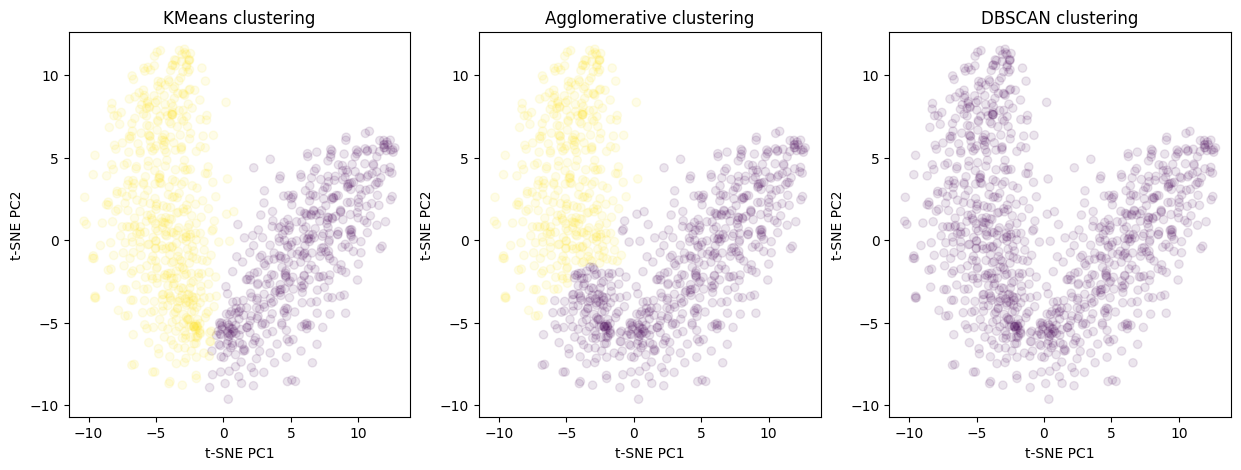

In [17]:
from sklearn.manifold import TSNE

# import h5 data
path = "/content/data/scRNA_counts.h5"
with h5py.File(path, 'r') as f:
    X = f['X'][:]
print(X[:5])

X = StandardScaler().fit_transform(X)
# perform t-SNE
perplexity = 20 # Note that the perplexity is a hyperparameter that you can tune, you should look into what it does and how to tune it
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0)
X_tsne = tsne.fit_transform(X)

from sklearn.cluster import KMeans
# Perform KMeans clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_tsne)
labels_kmeans = kmeans.labels_

from sklearn.cluster import AgglomerativeClustering
agglomerative = AgglomerativeClustering(n_clusters=2)
labels_agglomerative = agglomerative.fit_predict(X_tsne)

from sklearn.cluster import DBSCAN
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.1).fit(X_tsne)
labels_dbscan = dbscan.labels_

# Add all figures to the same plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_kmeans, alpha=0.1)
ax[0].set_xlabel('t-SNE PC1')
ax[0].set_ylabel('t-SNE PC2')
ax[0].set_title('KMeans clustering')
ax[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_agglomerative, alpha=0.1)
ax[1].set_xlabel('t-SNE PC1')
ax[1].set_ylabel('t-SNE PC2')
ax[1].set_title('Agglomerative clustering')
ax[2].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_dbscan, alpha=0.1)
ax[2].set_xlabel('t-SNE PC1')
ax[2].set_ylabel('t-SNE PC2')
ax[2].set_title('DBSCAN clustering')
plt.show()


Q 10:

In [18]:
np.sum(pca.explained_variance_ratio_[0:2])

0.12682040400539552